In [156]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import pandas as pd
# read in data with NOAA VTEC Codes
data_file = 'data/VTEC Events for_  SCC019  Charleston -2019-02-14 0925.csv'
data_noaa = pd.read_csv(data_file, skiprows=1)

data_noaa["code"] =data_noaa["Phenomena"].astype(str).add(data_noaa["Significance"])

# define a function to read correct the dates
def make_date(dates_strings, format='%b %d %Y %H:%M:%S'):
    for d in dates_strings:
        d = d[4:24]
        date = pd.to_datetime(d, format=format)
        yield date
        
# correct all the date formats
date_cols = ['Issued','Expired' ]
for col in date_cols:
    data_noaa[col] = list(make_date(data_noaa[col]))
print(data_noaa.head(2))
print(data_noaa.shape)

   Event ID            Phenomena Significance              Issued  \
0         5  Severe Thunderstorm      Warning 1986-06-01 17:07:00   
1         7  Severe Thunderstorm      Warning 1986-06-18 14:25:00   

              Expired                        code  
0 1986-06-01 17:50:00  Severe ThunderstormWarning  
1 1986-06-18 15:04:00  Severe ThunderstormWarning  
(1608, 6)


In [157]:


# pivot out data where columns by Phenomena (whcih are NOAA VTEC codes by issued date
data_noaa_agg = pd.pivot_table(data_noaa[['code', 'Issued']], index='Issued', columns='code', aggfunc=len)
data_noaa_agg.fillna(0)
# aggregates data by day
data_noaa_normalized = data_noaa_agg.groupby(data_noaa_agg.index.normalize()).sum()
max_date_noaa = max(data_noaa_normalized.index)
print(data_noaa_normalized.head(2))




code        Areal FloodAdvisory  Areal FloodWarning  Flash FloodWarning  \
Issued                                                                    
1986-06-01                  0.0                 0.0                 0.0   
1986-06-18                  0.0                 0.0                 0.0   

code        FloodWarning  Severe ThunderstormWarning  \
Issued                                                 
1986-06-01           0.0                         1.0   
1986-06-18           0.0                         1.0   

code        Severe ThunderstormWatch  TornadoWarning  TornadoWatch  
Issued                                                              
1986-06-01                       0.0             0.0           0.0  
1986-06-18                       0.0             0.0           0.0  


In [144]:
## pull in appointment data
from easy_sql.io import Session
dsn = 'statmods'
sql = '[StatisticalModels].[dbo].[Appt_Cancel_Weather_Analysis]'
s = Session(dsn)
data = s.get_data(sql)
data.index = data['Appt Date']
print(data.head(2))
print(data.shape)

             Appt Date  Month  FiscalYearNumber  Completed_Appts  \
Appt Date                                                          
2015-03-04  2015-03-04  March              2015             3741   
2015-03-06  2015-03-06  March              2015             2887   

            All_Cancelled_Appts  No_Show_Appts  Possible_No_Shows  \
Appt Date                                                           
2015-03-04                 1238            423               4164   
2015-03-06                 1001            366               3253   

            All_Cancelled_within_24hrs  Pat_Cancelled_Appts  \
Appt Date                                                     
2015-03-04                         518                  775   
2015-03-06                         402                  594   

            Pat_Cancelled_within_24hrs  Prov_Cancelled_Appts  No Show Rate  \
Appt Date                                                                    
2015-03-04                         324   

In [160]:

# filter out from appointment data, dates where there are no warnings data after 
data = data.loc[pd.to_datetime(data['Appt Date']) <= max_date_noaa]
# Join two data sets together using appt data and issue date
data_merged = pd.merge(data, data_noaa_normalized.copy(), how='left', left_index=True, right_index=True)
# fill all nulls with zero
data_merged.fillna(0, inplace=True)
# drop un used columns
data_merged.drop(['Appt Date', 'Month', 'FiscalYearNumber',], axis=1, inplace=True)
# aggregate weekly
# data_merged = data_merged.resample('w').sum()
print(data_merged.columns)
print(data_merged.shape)

Index(['Completed_Appts', 'All_Cancelled_Appts', 'No_Show_Appts',
       'Possible_No_Shows', 'All_Cancelled_within_24hrs',
       'Pat_Cancelled_Appts', 'Pat_Cancelled_within_24hrs',
       'Prov_Cancelled_Appts', 'No Show Rate', 'Pat_Same_Day_Cancel_Rate',
       'Areal FloodAdvisory', 'Areal FloodWarning', 'Flash FloodWarning',
       'FloodWarning', 'Severe ThunderstormWarning',
       'Severe ThunderstormWatch', 'TornadoWarning', 'TornadoWatch'],
      dtype='object')
(1673, 18)


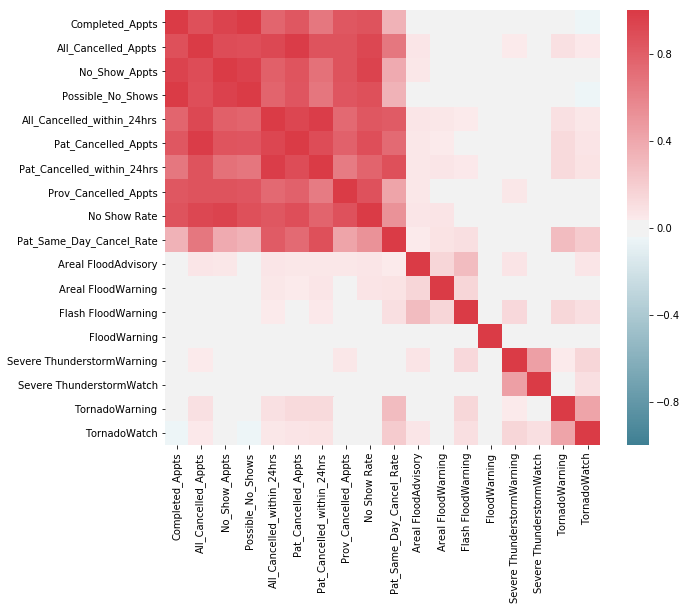

In [161]:
from matplotlib import pyplot as plt
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, vmin=-1, vmax=1 )


In [153]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

target_col = 'Pat_Same_Day_Cancel_Rate'
x_cols = data_noaa_normalized.columns
# select out x and y variables 
y = data_merged[target_col]
x = data_merged[x_cols]



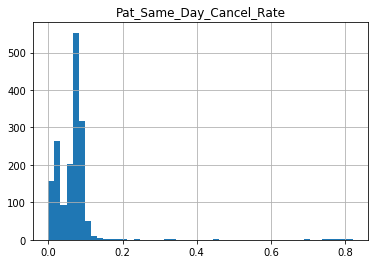

In [162]:
plt.figure()
data_merged[target_col].hist(bins = 50)
plt.title(target_col)
plt.show()

In [163]:
# this trains a model using cross validated grid search over a paremeter grid
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score, r2_score, mean_absolute_error
model = DecisionTreeRegressor()
params = {'max_depth': [2,3,4,5], 'min_samples_split': [5,10, 15], 'max_leaf_nodes': [4, 6, 8, 10, 12],
         'min_samples_leaf': [3, 6, 8, 10]}
model_cv = GridSearchCV(model, params, cv=5, scoring='r2', n_jobs=32)
model_cv.fit(x, y)
model = model_cv.best_estimator_ 
preds = model.predict(x)
score =  r2_score(y, preds)
print(f'r2 score:{score}')

r2 score:0.2459183164265698


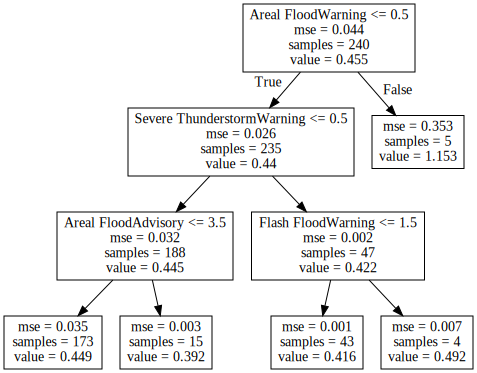

In [164]:
# plot a decision Tree
%matplotlib inline
from graphviz import Source
from sklearn import tree
from IPython.display import SVG
graph = Source(tree.export_graphviz(model, out_file=None, feature_names=x_cols))
SVG(graph.pipe(format='svg'))


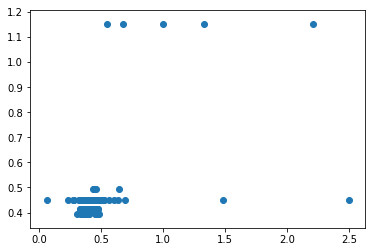

In [167]:
plt.figure()
plt.scatter(y, preds)

In [169]:
# build a possion regression model

X = sm.add_constant(x, prepend=False)
glm = sm.GLM(y, X, family=sm.families.Poisson())
res = glm.fit()
print(res.summary())



                    Generalized Linear Model Regression Results                     
Dep. Variable:     Pat_Same_Day_Cancel_Rate   No. Observations:                  240
Model:                                  GLM   Df Residuals:                      231
Model Family:                       Poisson   Df Model:                            8
Link Function:                          log   Scale:                          1.0000
Method:                                IRLS   Log-Likelihood:                -167.46
Date:                      Thu, 21 Feb 2019   Deviance:                       8.9649
Time:                              11:26:34   Pearson chi2:                     14.7
No. Iterations:                           4   Covariance Type:             nonrobust
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Areal FloodAdvisory           -0.0220      0.

In [114]:
# expoentiate params to se what the impack is.
np.exp(res.params)


Areal FloodAdvisory           0.978298
Areal FloodWarning            1.642503
Flash FloodWarning            1.068836
FloodWarning                  1.024302
Severe ThunderstormWarning    0.986925
Severe ThunderstormWatch      0.922731
TornadoWarning                1.049802
TornadoWatch                  1.086284
const                         0.446613
dtype: float64

In [171]:
preds = res.predict(X)
score =  r2_score(y, preds)
print(f'r2 score:{score}')

r2 score:0.32954788731380946


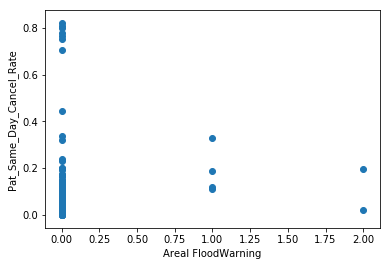

In [173]:
x1 = data_merged['Areal FloodWarning']
y1 = data_merged[target_col] 
plt.figure()
plt.scatter(x1, y1)
plt.xlabel('Areal FloodWarning')
plt.ylabel(target_col)
plt.show()


## This a header
+ bullets
+ bullets
    * different bullets
write some stuff

### other header

In [166]:
max(data[target_col])

0.820097739767868

In [174]:
data_merged.loc[data_merged['Areal FloodWarning']> 0]

,Completed_Appts,All_Cancelled_Appts,No_Show_Appts,Possible_No_Shows,All_Cancelled_within_24hrs,Pat_Cancelled_Appts,Pat_Cancelled_within_24hrs,Prov_Cancelled_Appts,No Show Rate,Pat_Same_Day_Cancel_Rate,Areal FloodAdvisory,Areal FloodWarning,Flash FloodWarning,FloodWarning,Severe ThunderstormWarning,Severe ThunderstormWatch,TornadoWarning,TornadoWatch
Appt Date,,,,,,,,,,,,,,,,,,
2016-10-12,3278,1303,492,3770,645,975,511,197,0.130504,0.119365,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-08,183,39,2,185,19,22,4,1,0.010811,0.021164,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
2018-07-20,2278,1364,339,2617,759,1036,639,177,0.129538,0.196253,7.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
2015-10-09,2718,1181,303,3021,491,847,378,195,0.100298,0.111209,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09-12,1834,1788,539,2373,642,1445,540,225,0.227139,0.185376,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-10-05,1795,2259,704,2499,1382,1864,1229,238,0.281713,0.329667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
